<a href="https://colab.research.google.com/github/chunming1022/-/blob/main/w2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
a=torch.tensor([[1,2,4],[1,3,9],[1,4,16]])
b=torch.tensor([[1,2,3,0],[1,4,6,0],[1,3,3,0]])
a/a[...,None,-1]

tensor([[0.2500, 0.5000, 1.0000],
        [0.1111, 0.3333, 1.0000],
        [0.0625, 0.2500, 1.0000]])

In [15]:
import torch
import matplotlib.pyplot as plt

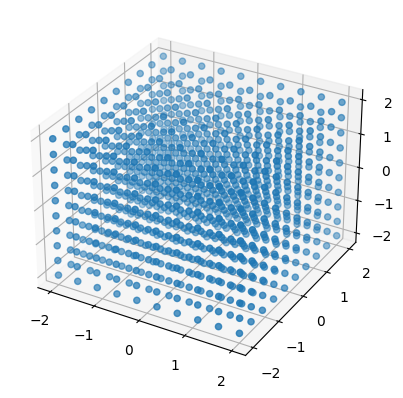

In [96]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import projections
import numpy as np

length=4
points_num=10
z, y, x=torch.meshgrid(
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32),
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32),
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32)
      )
points=torch.stack(
    [x, -y, z, torch.zeros_like(x)],
    dim=-1
)
ax=plt.figure().add_subplot(projection='3d')
ax.scatter(
      points[...,0],
      points[...,1],
      points[...,2])

In [112]:
c2w=torch.tensor([[6.8935126e-01, 5.3373039e-01, -4.8982298e-01, -1.9745398e+00],
   [-7.2442728e-01 , 5.0788772e-01 ,-4.6610624e-01, -1.8789345e+00],
   [ 1.4901163e-08 , 6.7615211e-01 , 7.3676193e-01 , 2.9699826e+00],
   [ 0.0000000e+00 , 0.0000000e+00 , 0.0000000e+00 , 1.0000000e+00]])
origin=c2w[:3,-1].expand(points.shape[0], points.shape[1], points.shape[2], 3)
origin=torch.cat((origin, torch.zeros(points.shape[0], points.shape[1], points.shape[2], 1)), -1)
location_in_mask=torch.sum((points-origin)[...,None,:-1]*(c2w[:3,:3].inverse()),dim=-1)
location_in_mask=-location_in_mask/location_in_mask[...,None,-1]

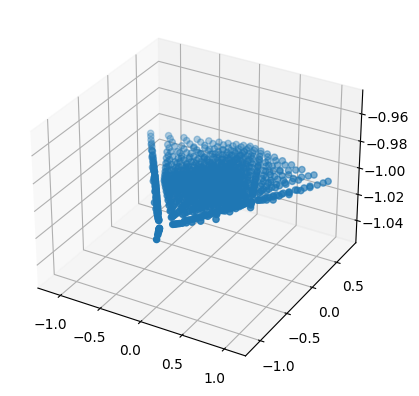

In [111]:
ax=plt.figure().add_subplot(projection='3d')
ax.scatter(
      location_in_mask[...,0],
      location_in_mask[...,1],
      location_in_mask[...,2])

In [ ]:
def init_space(
    length: int,
    points_num: int
) -> torch.Tensor:
  r"""
  Initialize n^3 points in the space of length*length*length.
  """
  z, y, x = torch.meshgrid(
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32),
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32),
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32)
      )
  points = torch.stack(
      [x, -y, z],
      dim=-1
  )
  return points

In [ ]:
def vote_building(
    c2w: torch.Tensor,
    points: torch.Tensor,
    mask_result: torch.Tensor,
    focal_length: float
    ):
  r"""
  Mapping spatial points to semantic matrices for voting on building categories
  """
  origin = c2w[:3,-1].expand(points.shape)
  location_in_camera = torch.sum((points-origin)[..., None, :]*(c2w[:3, :3].inverse()), dim=-1)
  location_in_camera = -location_in_camera/location_in_camera[..., None, -1]
  a = [location_in_camera.shape[i] for i in range(len(location_in_camera.shape))]
  location_in_camera = location_in_camera.reshape(a[0]*a[1]*a[2], a[3])
  h, w = mask_result.shape
  j, i = torch.meshgrid(
      torch.arange(h, dtype=torch.float32),
      torch.arange(w, dtype=torch.float32),
      indexing='ij')
  mask_in_camera = torch.stack([(i - w * .5) / focal_length,
                            -(j - h * .5) / focal_length,
                            -torch.ones_like(i)
                           ], dim=-1)
  